In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer
from scipy.ndimage import convolve


In [2]:
%run -i ncbx_funcs.py

Shape of xisl, yisl:  (1057, 1317) (1057, 1317)
Index of shoreline and y-location:
[168] [329.27781985]
Offshore model domain (dy_offshore):  [4453.85735021] , onshore (dy_onshore):  [5530.01136684]


In [3]:
url_CSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/dorian_his.ncml'
url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
url_FSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/dorian_his.ncml'
url_FSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/dorian_his.ncml'
run = 'CSYV'
ds_CSYV = xr.open_dataset(url_CSYV)


In [4]:
# load lat/lon, convert to island coordinates
lon = np.squeeze( ds_CSYV.lon_rho.load().values )
lat = np.squeeze( ds_CSYV.lat_rho.load().values )

# Convert lat/lon to UTM zone 18N, and then to island coordinates
transformer = Transformer.from_crs( 'epsg:4326', 'epsg:26918',  ) # WGS84 to UTM18
utmx, utmy = transformer.transform( lat, lon )
xisl, yisl = UTM2Island(utmx, utmy, eoff=383520.0, noff=3860830.0, rot=42.0)
print('Shape of xisl, yisl: ', xisl.shape, yisl.shape)

Shape of xisl, yisl:  (1057, 1317) (1057, 1317)


In [5]:
bt = ds_CSYV.bed_thickness[0,:,:,:].load().values

In [6]:
# load initial and final bathymetry - for most of these plots, we will look at CSYV
# Minus sign converts from depth to elevation
bathi = -ds_CSYV.bath[1,:,:].load().values
bathf = -ds_CSYV.bath[-1,:,:].load().values
bdiff = bathf - bathi

# smooth bathy for making contour maps
# experimenting with size of kernal suggest 15 is ok
ik = 15
k = np.ones((ik, ik)) / (ik*ik)
bathis = convolve(bathi,k,mode='nearest')
bathfs = convolve(bathf,k,mode='nearest')

# area calculations
pm = ds_CSYV.pm[:,:].load().values
pn = ds_CSYV.pn[:,:].load().values
area = 1./pm * 1./pn
print('Shape of area: ', area.shape)

vdiff = bdiff * area
print(np.sum(area))
print(np.sum(bdiff))
print(np.sum(vdiff))
print('bdiff')
stat_summary(bdiff, iprint=True)
print('vdiff')
stat_summary(vdiff, iprint=True)

Shape of area:  (1057, 1317)
19821987.311535504
-70593.43
243145.0925447774
bdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : -0.051 0.353 -4.542 1.478
  d5, d25, d50, d75, d95: -0.410 -0.023 0.001 0.018 0.196
vdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : 0.175 1.929 -49.830 70.158
  d5, d25, d50, d75, d95: -1.315 -0.134 0.005 0.146 2.611


{'n': 1057,
 'nnan': 0,
 'nvalid': 1057,
 'mean': 0.1746645407266288,
 'std': 1.9289193419431026,
 'min': -49.83044298234731,
 'max': 70.15775635512807,
 'd5': -1.315193128668792,
 'd25': -0.1340415790105609,
 'd50': 0.0045960437262363195,
 'd75': 0.146177606007145,
 'd95': 2.6111112905774303}

In [7]:
# Use a central line for cross-shore distance
y = np.squeeze( yisl[:,550] )

# find the average shoreline location
mbathi = np.mean(bathi[:,100:1200], axis=1)
mbathf = np.mean(bathf[:,100:1200], axis=1)
ishorey = np.argwhere(mbathi>=0.)[0]
print(ishorey, y[ishorey])

# hardwire this number for consistency
ishorey = 168

# use this for the cross-shore location by adding the offset
offset = y[ishorey]
y = y-offset
yisl = yisl-offset
xisl = xisl-np.min(xisl[ishorey])
# make the alongshore coordinates
x = np.squeeze( xisl[ishorey] - np.min(xisl[ishorey]) )

[168] [329.27781985]


Contour intervals:  [-10.  -8.  -6.  -4.  -2.   0.   2.]


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_22636\1114788641.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0 = ax0.pcolormesh(xisl,yisl, bathi,cmap='terrain',vmin=-2,vmax=5)


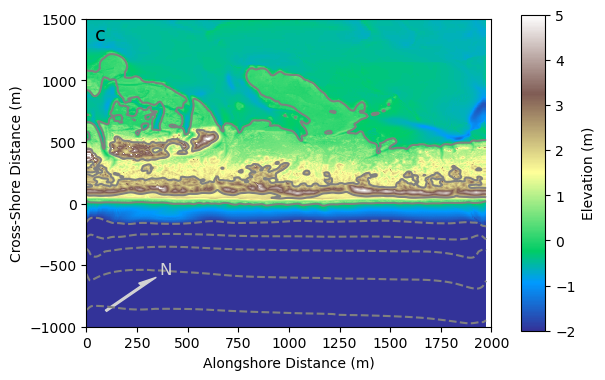

In [9]:
#### Initial bathy only
xs = 0
xe = 2000
ys = -1000
ye = 1500
levels = np.array( [-10, -8, -6, -4, -2, 0., 2.] )
print('Contour intervals: ', levels)
# north arrow calcs
# rot = 42
adx,ady = xycoord(.12, 90-42)

fig, ax0 = plt.subplots(1,1,figsize=(6,4),sharex=True)
m0 = ax0.pcolormesh(xisl,yisl, bathi,cmap='terrain',vmin=-2,vmax=5)
m0c = ax0.contour(xisl,yisl, bathis,levels,colors='gray',vmin=-2,vmax=5)
# ax0.plot(650,750,'oy',label='Sound')
# ax0.plot(650,50,'or',label='Ocean')
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
#ax0.text(0.35, 0.9, '{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
ax0.arrow( .05, .05,  adx, ady, shape = 'right', width=.01, color='lightgray', transform=ax0.transAxes )
ax0.text( .05+adx+.04, .05+ady+.04,'N',fontsize=12, color='lightgray', transform=ax0.transAxes )
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.1, 0.04, .79])
fig.colorbar(m0, cax=cbar_ax, label='Elevation (m)')
ax0.set_ylabel('Cross-Shore Distance (m)')
ax0.set_xlabel('Alongshore Distance (m)')
ax0.text(.02, .98, 'c', horizontalalignment='left', verticalalignment='top', transform=ax0.transAxes, fontsize=14)

figname = 'fig1c_init_bathy.png'
plt.savefig( figname, dpi=200, bbox_inches='tight') 